In [40]:
from dotenv import load_dotenv

load_dotenv()

True

In [41]:
import os
import shutil
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from typing import Literal, Optional

from rag_agent import ChatHistory

# 메모리 컨텍스트 저장 변수
stored_resume: Optional[str] = None
stored_jd: Optional[str] = None
base_chain_inputs: Optional[dict] = None
# RAG 벡터 스토어
vectorstore: Optional[Chroma] = None
# 영속 디렉토리 설정 (환경변수 또는 기본 경로)
persist_directory = os.getenv(
    "CHROMA_DB_PATH",
    os.path.join(os.getcwd(), "rag_agent/vectorstore/chroma_db")
)

chat_history = ChatHistory.get_instance()

# 로컬 파일 시스템에서 context와 회사 자료 자동 로딩
# TODO: RAG PyPDF2 -> langchain vector db
def parse_file_to_text(file_path: str) -> str:
    with open(file_path, "rb") as f:
        content = f.read()
    try:
        return content.decode("utf-8")
    except UnicodeDecodeError:
        if file_path.lower().endswith(".pdf"):
            loader = PyPDFLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        elif file_path.lower().endswith((".docx", ".doc", ".txt")):
            loader = TextLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        else:
            return content.decode("utf-8", errors="ignore")
        
def get_company_info():
    # 회사 자료 검색
    retrieved = vectorstore.similarity_search(stored_jd, k=3)
    company_info = "\n".join([doc.page_content for doc in retrieved])
    # Trim company_info to avoid exceeding model context window
    max_company_info_length = 2000
    if len(company_info) > max_company_info_length:
        company_info = company_info[:max_company_info_length]
    return company_info


base_dir = os.path.join(os.getcwd(), "data")
# 이력서 로딩
resume_dir = os.path.join(base_dir, "resume")
for fname in os.listdir(resume_dir):
    stored_resume = parse_file_to_text(os.path.join(resume_dir, fname))
    break
# JD 로딩
jd_dir = os.path.join(base_dir, "jd")
for fname in os.listdir(jd_dir):
    stored_jd = parse_file_to_text(os.path.join(jd_dir, fname))
    break
# 회사 자료 로딩 및 인덱싱
company_dir = os.path.join(base_dir, "company_infos")
docs = []
for fname in os.listdir(company_dir):
    text = parse_file_to_text(os.path.join(company_dir, fname))
    splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    for chunk in splitter.split_text(text):
        docs.append(Document(page_content=chunk, metadata={"filename": fname}))
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(
    persist_directory=persist_directory, embedding_function=embeddings
)
stored_company_info = get_company_info()
base_chain_inputs = {
    "resume": stored_resume,
    "jd": stored_jd,
    "company_infos": stored_company_info,
}
if docs:
    texts = [d.page_content for d in docs]
    metadatas = [d.metadata for d in docs]
    vectorstore.add_texts(texts=texts, metadatas=metadatas)
    vectorstore.persist()

23:39:44 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
23:39:44 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [42]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from rag_agent import ChatHistory

class AgentState(TypedDict):
    query: str # 사용자 답변
    answer: str # Agent 답변
    input_type: str # 사용자 답변 유형
    persona_id: str # 페르소나 ID
    route_type: str # routing 결과
    resume: str # 자소서(이력서)
    jd: str # 채용공고
    company: str # 회사정보 (인재상)
    chat_history: ChatHistory # 대화내역
    last_question: str #마지막 질문        

In [43]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

import os

llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"), temperature=0.7, model_name="gpt-4o-mini"
)


In [44]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate

def classify_input(state: AgentState) -> AgentState:
    """
    사용자 입력을 바탕으로 현재 입력이 어떤 형식인지 분류하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (AgentState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    query = state.get("query", "")
    print("classify_input > query >", query)
    
    classify_prompt = PromptTemplate.from_template("""
주어진 query와 chat_history를 바탕으로 입력이이 어떤 유형인지 판단하세요: 
- 면접질문 요청 (question)
- 꼬리질문 요청 (followup)
- 모범답변 요청 (modelAnswer)
- 답변 (answer)
- 그 외 면접과 관련 없는 텍스트 (other)


사용자 입력:
{query}

형식: question, followup, modelAnswer, answer, other 중 하나로만 답하세요.
""")
    
    router_chain = classify_prompt | llm | StrOutputParser() 
    result = router_chain.invoke({'query': query})
    
    print("classify_input", result)
    # # 분류 결과 추출 (마지막 메시지의 content가 분류값)
    # classification = result['messages'][-1].content.strip()
    
    # 결과 메시지를 업데이트하고 router node로 이동합니다.
    return { 
        "input_type": result
    }

In [45]:
from rag_agent import PersonaService
from rag_agent.persona.Persona import Persona, PersonaType
from rag_agent.persona.PersonaService import PersonaInput

persona_service = PersonaService.get_instance()
# persona_service.set_context(stored_resume, stored_jd)
# 페르소나 추가 (테스트용)
persona_service.add_persona(
    PersonaInput(
        name="Recruiter",
        type="other",
        interests=["조직 적응력", "인성"],
        communicationStyle="차분하고 상냥한 스타일",
    )
)
persona_service.add_persona(
    PersonaInput(
        name="CTO",
        type="developer",
        interests=["이슈 해결 과정과 Lessons Learned"],
        communicationStyle="불필요한 말은 하지 않음, 합리적이고 이성적인 스타일",
    )
)

def assign_persona_node(state: AgentState) -> AgentState:
    """
    페르소나 할당 node입니다. 주어진 state를 기반으로 assign_persona 에이전트를 호출하고,
    결과를 router node로 전달합니다.

    Args:
        state (AgentState): 현재 메시지 상태 객체.

    Returns:
        Command: router node로 이동 명령을 반환.
    """
    print(state)
    resume = state.get("resume", "")
    jd = state.get("jd", "")
    company = state.get("company", "")
    query = state.get("query", "")
    last_question = state.get("last_question", "")
    persona_id = persona_service.invoke_agent(resume, jd, company, query, last_question)
    print("assign_persona_node", persona_id)
    
    return { "persona_id": persona_id }
    

In [46]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['question', 'model_answer', 'followup', 'llm'] = Field(
        description="The target for the query to answer"
    )

def router(state: AgentState) -> AgentState:
    """
    주어진 state에서 input_type를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['question', 'model_answer', 'followup', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    
    router_system_prompt = """
You are an expert at routing a user's input type to 'question', 'model_answer', 'followup' or 'llm'.
If the user input is 'question' route to 'question'.
else if the user input is 'model_answer' route to 'model_answer',
else if the user input is 'followup' route to 'followup',

if you think the input is not related to either 'question', 'model_answer' or 'followup';
you can route it to 'llm'."""
    
    router_prompt = ChatPromptTemplate.from_messages([
        ('system', router_system_prompt),
        ('user', '{query}')
    ])

    structured_router_llm = llm.with_structured_output(Route)

    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})
    print("router", route)

    return { "route_type": route }



In [47]:
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

def generation(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 면접 질문을 생성하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
                
        generation_prompt = PromptTemplate.from_template(
            """다음은 지원자의 자소서, JD(직무기술서), 회사 정보, 그리고 면접관 페르소나입니다:

            자기소개서:
            {resume}

            JD:
            {jd}

            회사 정보:
            {company}

            면접관 페르소나:
            {persona}

            당신은 위 페르소나를 기반으로 하는 면접관입니다.
            다음 단계를 거쳐 면접 질문을 생성하세요:

            1단계 - 분석 (Reasoning):
            - 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
            - JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
            - 부족하거나 확인이 필요한 부분은 무엇인가?
            - 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

            2단계 - 질문 생성 (Acting):
            - 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
            - 면접관 페르소나의 말투와 스타일을 반영

            출력 형식:
            [2단계에서 생성된 면접 질문]
            """
        )

        chain = generation_prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume, 
            "jd": jd, 
            "company": company, 
            "persona": persona
        })
        print("result", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Generation 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [25]:
# from langchain.prompts import PromptTemplate, ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
# from langchain_core.tools import tool

# import json

# class AssessmentResult(BaseModel):
#     logicScore: int
#     jobFitScore: int
#     coreValueFitScore: int
#     communicationScore: int
#     averageScore: float

# def evaluate_answer(state: AgentState) -> AgentState:
#     """
#     이전 대화내용을 기반으로 사용자 입력을 평가하고
#     결과를 router node로 전달합니다.
    
#     Args:
#       state (AgentState): 현재 메시지 상태를 나타내는 객체입니다.
    
#     Returns:
#       Command: router node로 이동하기 위한 명령을 반환합니다.
#     """

#     parser = JsonOutputParser(pydantic_object=AssessmentResult)
    
#     # 상태에서 필요한 정보 추출
#     resume = state.get("resume", "")
#     jd = state.get("jd", "")
#     company = state.get("company", "")
#     persona = state.get("persona", "")
#     last_question = state.get("last_question", "")
        
#     assessment_prompt = PromptTemplate(
#         input_variables=["resume", "jd", "company", "last_question", "answer", "persona"],
#         template="""
#         역할: 면접관으로서 지원자의 답변을 평가합니다.

#         직무 설명:
#         {jd}

#         이력서:
#         {resume}

#         회사 정보:
#         {company}

#         질문: 
#         {last_question}
        
#         지원자의 답변:
#         {answer}

#         면접관 정보:
#         {persona}
        
#         다음 4개 항목을 0-10점으로 평가하세요:
#         1. 논리성 (logicScore): 답변의 논리적 일관성과 구조
#         2. 직무적합성 (jobFitScore): JD 요구사항과의 부합도
#         3. 핵심가치 부합성 (coreValueFitScore): 회사 가치와의 일치도
#         4. 커뮤니케이션 능력 (communicationScore): 의사소통 명확성

#         {format_instructions}
#         """,
#         partial_variables={"format_instructions": parser.get_format_instructions()}
#     )

#     chain = assessment_prompt | llm | parser
    
#     try:
#         result = chain.invoke({
#             "jd": jd,
#             "resume": resume,
#             "company": company,
#             "question": question,
#             "answer": answer,
#             "persona": persona,
#         })
#         return result
#     except Exception as e:
#         return {"error": "평가 중 오류가 발생했습니다."}

In [48]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

def followup(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 현재 입력에 대한 꼬리질문을 생성하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
        chat_history = state.get("chat_history", "")
        query = state.get("query", "")
                
        followup_prompt = PromptTemplate.from_template(
            """아래는 AI 면접 시스템에서 지금까지 진행된 대화입니다:

대화 이력:
{chat_history}

현재 질문에 대한 지원자의 답변:
{query}

자기소개서:
{resume}

JD:
{jd}

회사 정보:
{company}

면접관 페르소나:
{persona}

당신은 위 페르소나를 기반으로 하는 면접관입니다.
다음 단계를 거쳐 면접 질문을 생성하세요:

1단계 - 분석 (Reasoning):
- 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
- JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
- 부족하거나 확인이 필요한 부분은 무엇인가?
- 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

2단계 - 질문 생성 (Follow-up Question):
- 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
- 면접관 페르소나의 말투와 스타일을 반영

출력 형식:
[생성된 꼬리 면접 질문]
"""
        )

        chain = followup_prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume, 
            "jd": jd, 
            "company": company, 
            "persona": persona,
            "chat_history": chat_history,
            "query": query,
        })
        print("result", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Followup 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [49]:
def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    query = state['query']
    llm_chain = llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer }

In [55]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
import os

from typing import TypedDict, List, Dict, Any
import json

# LLM 정의
llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.7,
    model_name="gpt-4"
)


def model_answer(state: AgentState) -> AgentState:
    """
    STAR 기법 등 구조화된 최적의 모범 답변을 생성하는 LangGraph용 노드 함수.
    이력서, JD, 회사정보, 이전 Q&A, 질문, 페르소나 등 context를 모두 반영.
    """
    try:
        # 1. 상태에서 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company_infos = state.get("company", "")
        prev_question_answer_pairs = state.get("chat_history", "")
        question = state.get("last_question", "")
        persona = state.get("persona_id", "")
        chat_history = state.get("chat_history", "")

        # 2. 프롬프트 템플릿 정의
        prompt = PromptTemplate.from_template(
            """
아래는 AI 면접 시스템에서 지금까지 진행된 대화입니다:

상황:
{company_infos}

이력서:
{resume}

직무 설명:
{jd}

이전 질문/답변 쌍들:
{prev_question_answer_pairs}

현재 질문:
{question}

면접관 페르소나:
{persona}

대화 이력:
{chat_history}

---
당신은 위 페르소나를 기반으로 하는 면접관입니다.
주어진 질문에 대해 최적의 답변을 생성해야 합니다.
이 답변은 회사의 가치관, 직무 요구사항, 그리고 이력서의 내용을 모두 고려해야 합니다.

답변은 다음 형식을 따라야 합니다:

1. STAR 기법을 활용한 구조화된 답변:
   - Situation: 상황 설명
   - Task: 해결해야 할 과제
   - Action: 취한 행동
   - Result: 결과와 배운 점

2. 직무 관련성:
   - JD에서 요구하는 역량과의 연관성
   - 회사의 핵심 가치와의 부합성

3. 구체성:
   - 구체적인 숫자와 데이터 포함
   - 실제 경험 기반의 예시

4. 논리성:
   - 명확한 인과관계
   - 체계적인 설명

답변은 한글로 생성해야 한다.

"""
        )

        # 3. LLM 체인 실행
        chain = prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume,
            "jd": jd,
            "company_infos": company_infos,
            "prev_question_answer_pairs": prev_question_answer_pairs,
            "question": question,
            "persona": persona,
            "chat_history": chat_history,
        })

        # 4. 결과를 state에 업데이트
        return {
            **state,
            "model_answer": result
        }

    except Exception as e:
        return {
            **state,
            "error": f"model_answer_node에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }

In [51]:
def conditional_router(state: AgentState) -> str:
    """
    그래프의 조건부 엣지에서 사용할 라우팅 함수
    
    Args:
        state (AgentState): 현재 상태
        
    Returns:
        str: 다음 노드 이름
    """
    # 상태에서 라우팅 정보 확인
    print(state)
    next_route = state.get('next_route', 'other')
    
    # 그래프 노드 이름과 매핑
    route_mapping = {
        'generation': 'generation',
        'question': 'generation',
        'answer': 'generation',
        'followup': 'followup',
        'model_answer': 'ModelAnswer', 
        'interview_answer': 'EvaluateFollowup',
        'other': 'llm'
    }
    
    return route_mapping.get(next_route, 'llm')

In [52]:

from langgraph.graph import START, END
    
graph_builder = StateGraph(AgentState)

# 노드 추가
graph_builder.add_node('classify_input', classify_input)
graph_builder.add_node('assign_persona', assign_persona_node)
graph_builder.add_node('router', router)
graph_builder.add_node('generation', generation)
graph_builder.add_node('followup', followup)
graph_builder.add_node('llm', call_llm)
graph_builder.add_node('model_answer', model_answer)

# 시작점에서 병렬 실행
graph_builder.add_edge(START, 'classify_input')
graph_builder.add_edge(START, 'assign_persona')

# 두 병렬 노드가 완료되면 라우터로
graph_builder.add_edge('classify_input', 'router')
graph_builder.add_edge('assign_persona', 'router')

# 생성 노드에서 종료
graph_builder.add_edge('generation', END)
graph_builder.add_edge('followup', END)
graph_builder.add_edge('llm', END)
graph_builder.add_edge('model_answer', END)

graph_builder.add_conditional_edges(
    'router',
    conditional_router,
    {
        "generation": "generation",
        "followup": "followup",
        "llm": "llm",
        "model_answer": "model_answer"
    }
)

In [53]:
graph = graph_builder.compile()

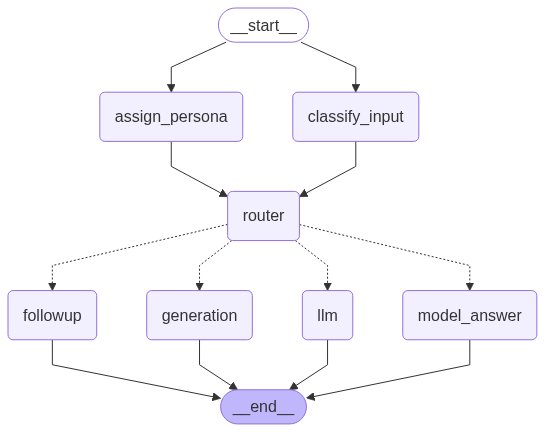

In [56]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
initial_state = { 
    "query": "떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘", 
    "resume": stored_resume, 
    "jd": stored_jd,
    "company": stored_company_info,
    "chat_history": chat_history.get_all_history_as_string(),
    "last_question": chat_history.get_question_by_id(
        chat_history.get_latest_question_id()
    ) 
}
graph.invoke(initial_state)


{'query': '떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘', 'resume': "John Doe\r\nSoftware Engineer\r\n\r\nEducation:\r\n- Bachelor's degree in Computer Science, XYZ University\r\n- Master's degree in Artificial Intelligence, ABC University\r\n\r\nExperience:\r\n- Senior Software Engineer at Tech Corp (2020-Present)\r\n- Software Engineer at Startup Inc (2018-2020)\r\n\r\nSkills:\r\n- Python, JavaScript, React\r\n- Machine Learning, NLP\r\n- Web Development\r\n- Cloud Computing ", 'jd': "Software Engineer Position\r\n\r\nRequirements:\r\n- Bachelor's degree in Computer Science or related field\r\n- 3+ years of experience in software development\r\n- Strong knowledge of Python and web frameworks\r\n- Experience with machine learning and NLP is a plus\r\n\r\nResponsibilities:\r\n- Develop and maintain web applications\r\n- Implement new features and improvements\r\n- Collaborate with team members\r\n- Write clean and maintainable code ", 'company': 'Tech Corp\r\n\r\nAbout Us:\r\nTech Corp is a leading techn

23:43:11 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


classify_input other


23:43:14 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\nnn15\anaconda3\envs\llm\Lib\site-packages\langchain_openai\chat_models\base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


assign_persona_node Thought: The applicant is a software engineer with experience in machine learning and NLP, which aligns with the job description. The applicant's interview response is in Korean, suggesting they might be comfortable communicating in this language. The CTO personas have interests in problem-solving and lessons learned, which aligns well with the software engineering role. Their communication style is rational and to the point, which is suitable for technical discussions.

Final Answer: 34215d83


23:43:15 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


router target='llm'
{'query': '떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘', 'input_type': 'other', 'persona_id': "Thought: The applicant is a software engineer with experience in machine learning and NLP, which aligns with the job description. The applicant's interview response is in Korean, suggesting they might be comfortable communicating in this language. The CTO personas have interests in problem-solving and lessons learned, which aligns well with the software engineering role. Their communication style is rational and to the point, which is suitable for technical discussions.\n\nFinal Answer: 34215d83", 'route_type': Route(target='llm'), 'resume': "John Doe\r\nSoftware Engineer\r\n\r\nEducation:\r\n- Bachelor's degree in Computer Science, XYZ University\r\n- Master's degree in Artificial Intelligence, ABC University\r\n\r\nExperience:\r\n- Senior Software Engineer at Tech Corp (2020-Present)\r\n- Software Engineer at Startup Inc (2018-2020)\r\n\r\nSkills:\r\n- Python, JavaScript, React\r\n- Machi

KeyboardInterrupt: 